# Multiple Edits Notebook

In [1]:
import sys
import os 
sys.path.append(os.path.abspath(os.path.join("", "..")))
import torch
import gc
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
from lora_w2w import LoRAw2w
from utils import load_models, inference, save_model_w2w, save_model_for_diffusers
from editing import get_direction, edit_inference, debias
device = "cuda:0"

/nfs/usr/jwang23/miniconda3/envs/dblora/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Files

1) mean is 99648 dimensional tensor of the mean for each parameter in the original LoRA space.
2) std is 99648 dimensional tensor of the standard deviation for each parameter in the original LoRA space.
3) v is 99648x10000 dimensional tensor used to project or unproject the weights onto principal component representation in w2w space or to unproject back into the LoRA space.
4) proj is a 64974x1000 dimensional tensor where each row is a 1000 dimensional principal component representation for each identity-encoding model in our dataset of weights.
5) pinverse is the precomputed pseudoinverse of proj, used in obtaining the classifier directions given labels.
6) df is a pandas dataframe with each identity model in our dataset of weights and their associated binary labels. 
7) weight_dimensions is a dictionary of the dimensionality for each LoRA in the UNet. Used to save models in Diffusers pipeline format. 

In [2]:
mean = torch.load("../files/mean.pt").bfloat16().to(device)
std = torch.load("../files/std.pt").bfloat16().to(device)
v = torch.load("../files/V.pt").bfloat16().to(device)
proj = torch.load("../files/proj_1000pc.pt").bfloat16().to(device)
pinverse = torch.load("../files/pinverse_1000pc.pt").bfloat16().to(device)
df = torch.load("../files/identity_df.pt")
weight_dimensions = torch.load("../files/weight_dimensions.pt")

## Load Base Models

In [3]:
unet, vae, text_encoder, tokenizer, noise_scheduler = load_models(device)

Loading pipeline components...:  67%|██████▋   | 4/6 [00:00<00:00,  5.54it/s]

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  7.78it/s]


## Load up Identity Model in *w2w* Space

You can load a model from the dataset of *w2w* weights (proj), or you can load up one of the models from sampling or inversion.

In [4]:
weights0 = torch.load("../output/real_inversion_w2w/w2wmodel.pt").to(device)

In [5]:
# free up memory if reinitializing model
if 'network' in globals():
    del network
    network = None
    gc.collect()
    torch.cuda.empty_cache() 
    unet, _, _, _, _ = load_models(device)
# initialize model
network = LoRAw2w(unet = unet,
                proj = weights0, 
                mean = mean, 
                std = std, 
                v = v[:,:10000],
                rank=1,
                multiplier=1.0,
                alpha=27,
                train_method="xattn-strict",
                ).to(device, dtype=torch.bfloat16)

Original Identity

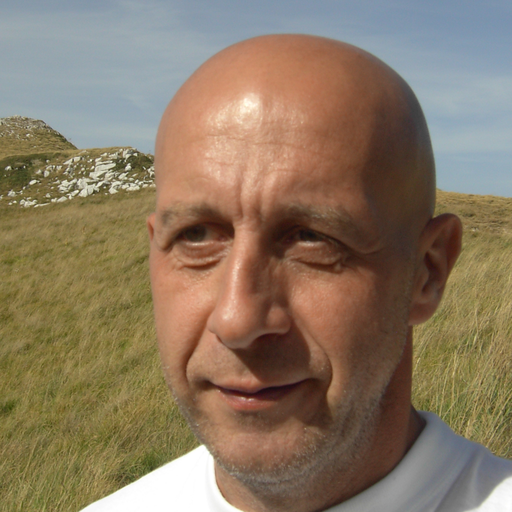

In [6]:
image = Image.open("../inversion/images/real_image/real/im/43883.png")
image.show()

## Get Semantic Directions

Below, we call the **get_direction** function which trains a linear classifier and returns a direction in weight space to edit the identity. If your model is represented by 10000 principal components, then the "return_dim" parameter should be 10000, if it is 1000 principal components, then 1000, etc.

### You can choose identity attributes from the following list:

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones','Male', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Lipstick', 'Young'].


In [84]:
direction1 = get_direction(df = df,label = "Bald", pinverse = pinverse, return_dim = 10000, device =device)
direction2 = get_direction(df = df,label = "Chubby", pinverse = pinverse, return_dim = 10000, device =device)

Some directions may be entangled. If you want, you can remove components from directions as shown below. For instance, the first line remove the "Chubby" component from direction1.

In [107]:
direction1 = debias(direction1, "Chubby", df, pinverse, device)
direction1 = debias(direction1, "No_Beard", df, pinverse, device)
direction1 = debias(direction1, "Young", df, pinverse, device)
direction1 = debias(direction1, "Big_Nose", df, pinverse, device)
direction1 = debias(direction1, "Pale_Skin", df, pinverse, device)

direction2 = debias(direction2, "Bald", df, pinverse, device)
direction2 = debias(direction2, "No_Beard", df, pinverse, device)
direction2 = debias(direction2, "Young", df, pinverse, device)
direction2 = debias(direction2, "Big_Nose", df, pinverse, device)
direction2 = debias(direction2, "Pale_Skin", df, pinverse, device)


Below, we edit the original identity with simple arithmetic operations with the multiple edit directions

In [124]:
weights1 = weights0-800000*direction1+1500000*direction2

In [125]:
# free up memory if reinitializing model
if 'network' in globals():
    del network
    network = None
    gc.collect()
    torch.cuda.empty_cache() 
    unet, _, _, _, _ = load_models(device)
# load in edited weights
network = LoRAw2w(unet = unet,
                proj = weights1, 
                mean = mean, 
                std = std, 
                v = v[:,:10000],
                rank=1,
                multiplier=1.0,
                alpha=27,
                train_method="xattn-strict",
                ).to(device, dtype=torch.bfloat16)

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 13.08it/s]


### The man now has hair and is chubbier.

  0%|          | 0/51 [00:00<?, ?it/s]

100%|██████████| 51/51 [00:02<00:00, 21.79it/s]


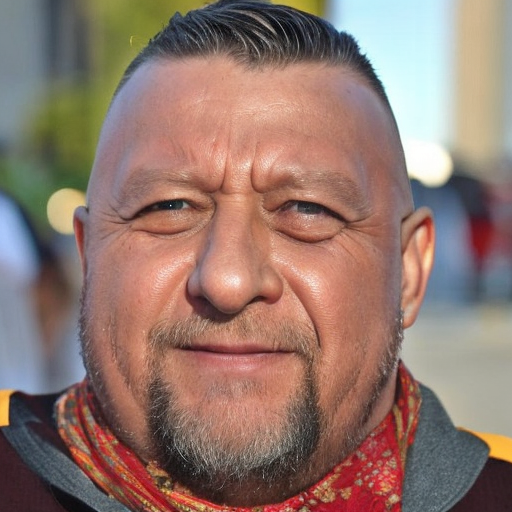

In [133]:
#inference parameters
prompt = "sks person" 
negative_prompt = "low quality, blurry, unfinished, cartoon" 
guidance_scale = 2.5
seed = 26
ddim_steps = 50

# random seed generator
generator = torch.Generator(device=device)

image = inference(network, unet, vae, text_encoder, tokenizer, prompt, negative_prompt, guidance_scale, noise_scheduler, ddim_steps, seed, generator, device)
image = image.detach().cpu().float().permute(0, 2, 3, 1).numpy()[0]
image = Image.fromarray((image * 255).round().astype("uint8"))
image.show()



If you are interested image editing/better preservation of context, we provide an inference function that uses delayed injection based on [**[1](https://arxiv.org/pdf/2304.08465)**,**[2](https://arxiv.org/pdf/2305.10431)**,**[3](https://arxiv.org/pdf/2311.12092)**]. After **T** timesteps, the edited weights are used instead of the original ones. You can play around with the edit strength, timestep **T** of injection, and guidance scale. Larger **T** in the range (700-1000) are helpful for more global attribute changes, while smaller (400-700) can be used for more finegrained edits.

In [134]:
weights1 = weights0-1500000*direction1
weights2 = weights1+1500000*direction2

In [135]:
# free up memory if reinitializing model
if 'network' in globals():
    del network
    network = None
    gc.collect()
    torch.cuda.empty_cache() 
    unet, _, _, _, _ = load_models(device)
# initialize model
network = LoRAw2w(unet = unet,
                proj = weights0, 
                mean = mean, 
                std = std, 
                v = v[:,:10000],
                rank=1,
                multiplier=1.0,
                alpha=27,
                train_method="xattn-strict",
                ).to(device, dtype=torch.bfloat16)

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 13.66it/s]


We progressively add the edits below.

  0%|          | 0/51 [00:00<?, ?it/s]

100%|██████████| 51/51 [00:02<00:00, 21.31it/s]


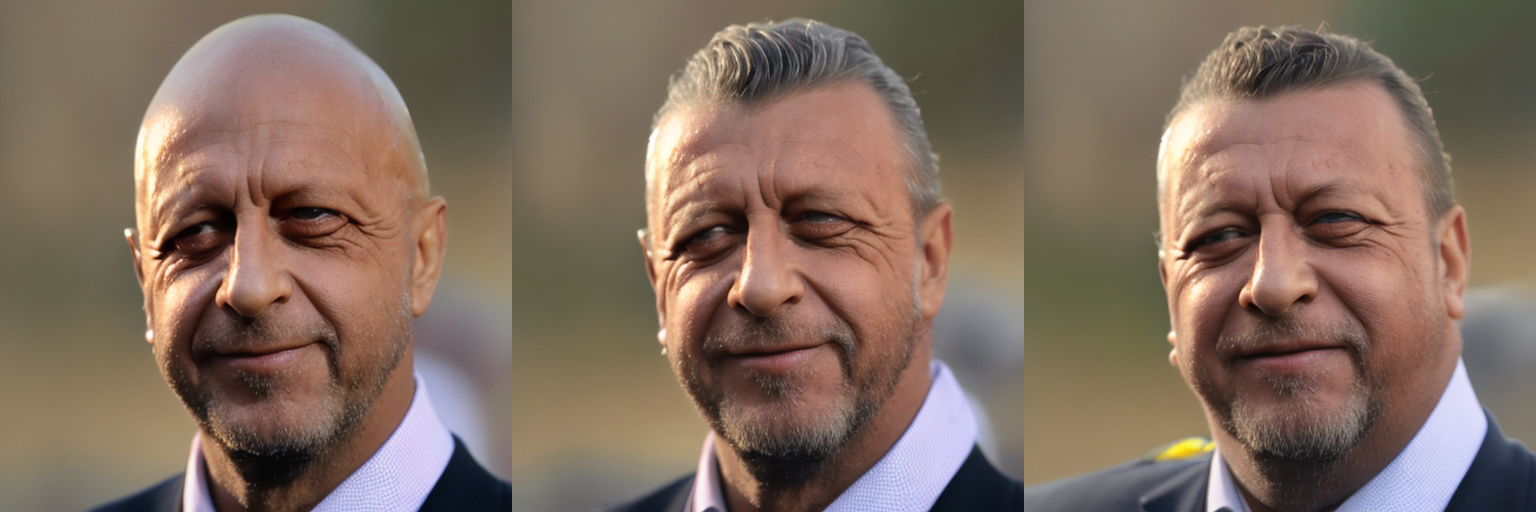

In [136]:
#inference parameters
prompt = "sks person" 
negative_prompt = "low quality, blurry, unfinished, cartoon" 
guidance_scale = 2.5
seed = 25
ddim_steps = 50
# injection step
start_noise = 800
# random seed generator
generator = torch.Generator(device=device)

images = []
#run inference
for weight in [weights0, weights1, weights2]:
    image = edit_inference(network, weight, unet, vae, text_encoder, tokenizer, prompt, negative_prompt, guidance_scale, noise_scheduler, ddim_steps, start_noise, seed, generator, device)
    image = image.detach().cpu().float().permute(0, 2, 3, 1).numpy()[0]
    image = Image.fromarray((image * 255).round().astype("uint8"))
    images.append(image)

### display images
w, h = 512,512
grid = Image.new('RGB', size=(3*512, 1*512))
grid_w, grid_h = grid.size
for i, img in enumerate(images):
    grid.paste(img, box=(i%3*w, i//3*h))
grid